### Import các thư viện cần dùng

In [44]:
import pandas as pd
import numpy as np
import chardet
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

### Ghép thêm bảng vào dữ liệu gốc

In [ ]:
#Kiểm tra định dạng file CSV muôn gộp vào dữ liệu gốc
with open(r'data/DimProductSubcategory.csv', 'rb') as f:
  result = chardet.detect(f.read(100000))  # Đọc 100KB đầu tiên
  print(result)  # Xem file có encoding gì

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


In [ ]:
df_subcategory = pd.read_csv(r'data/DimProductSubcategory.csv', 
                 delimiter="|", encoding="UTF-16", header=None)
#Xóa cột đầu tiên vì đây là index
df_subcategory = df_subcategory.iloc[:, 1:]
#Đặt tên cho các cột
df_subcategory.columns = ['ProductSubcategoryKey', 'EnglishProductSubcategoryName', 
                          'SpanishProductSubcategoryName', 
                          'FrenchProductSubcategoryName', 'ProductCategoryKey']

In [4]:
df_subcategory

,ProductSubcategoryKey,EnglishProductSubcategoryName,SpanishProductSubcategoryName,FrenchProductSubcategoryName,ProductCategoryKey
0,1,Mountain Bikes,Bicicleta de montaña,VTT,1
1,2,Road Bikes,Bicicleta de carretera,Vélo de route,1
2,3,Touring Bikes,Bicicleta de paseo,Vélo de randonnée,1
3,4,Handlebars,Barra,Barre d'appui,2
4,5,Bottom Brackets,Eje de pedalier,Axe de pédalier,2
5,6,Brakes,Frenos,Freins,2
6,7,Chains,Cadena,Chaîne,2
7,8,Cranksets,Bielas,Pédalier,2
8,9,Derailleurs,Desviador,Dérailleur,2
9,10,Forks,Horquilla,Fourche,2


In [ ]:
#Tạo dataset mới có bảng DimProductSubcategory từ df_subcategory và dataset gốc
df_origin = pd.ExcelFile('data/Dataset_Round2_2021_Sales.xlsx')
with pd.ExcelWriter('data/Dataset_DM&DW.xlsx', engine="openpyxl") as writer:
  # Ghi lại từng sheet cũ
  for sheet_name in df_origin.sheet_names:
    df_for = pd.read_excel(df_origin, sheet_name=sheet_name)
    df_for.to_excel(writer, sheet_name=sheet_name, index=False)  # Ghi lại sheet cũ
  # Thêm sheet mới từ CSV
  df_subcategory.to_excel(writer, sheet_name="DimProductSubcategory", index=False)

In [6]:
#Kiểm tra xem đã có sheet DimProductSubcategory chưa
df_new = pd.ExcelFile('Dataset_DM&DW.xlsx')
df_new.sheet_names 

['Product',
 'DimCurrency',
 'DimCustomer',
 'DimDate',
 'FactInternetSales',
 'SaleReason',
 'FactInternetSalesReason',
 'DimPromotion',
 'DimProductSubcategory']

### Đọc dữ liệu

In [3]:
df_product = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='Product')
df_subcategory = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='DimProductSubcategory')
df_customer = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='DimCustomer')
df_internetsale = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='FactInternetSales')
df_date = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='DimDate')

### Association Rules

In [8]:
df_product.shape

(771, 36)

In [9]:
print(df_product.duplicated().sum())

111


In [10]:
df_product[df_product.duplicated()][['ProductKey', 'EnglishProductName']]

,ProductKey,EnglishProductName
295,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
297,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
299,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
301,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
303,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
...,...,...
749,853207C067902C999EE8910889483499660FC00280411B...,אופניים אלה מספקים רמת ביצועים גבוהה במחיר סבי...
751,853207C067902C999EE8910889483499660FC00280411B...,אופניים אלה מספקים רמת ביצועים גבוהה במחיר סבי...
766,E2312F1A47E4E68F1C41550D93160944832264D41918D4...,"אופני מבוגרים למתחילים; מציעים רכיבה נוחה ""מחו..."
768,E2312F1A47E4E68F1C41550D93160944832264D41918D4...,"אופני מבוגרים למתחילים; מציעים רכיבה נוחה ""מחו..."


In [12]:
print(df_product['ProductKey'].unique())

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
 'C4A5076C811144C307604193D827EE3004ED205B5228577095DA3F0801FA780FFDCD863138FFC067F28B313C77B2494735AC813FB484023C832D14CF078CC001180108A841C1D96E20A4000B608D84A8437166C33074147800D686C746B965130198830E94C082B1530AC000A0FE260EA4ED0C28420F10C1348C023278438D87413621D2A8DD27008C677C289190DB45C07C498AF98F155572159A853E941237484036108025608102F800062401D90D4114AC590E6042097841198439462CC02C1467E7147A4EAE39AE0D5E46F10A08D0420737521B90030838C16F7A2018940219A04104D4AABF020049D984B41C43921A58F60080A3FFDC38034A011858E622C0E46C80125580207C020244408B57C1A7BC00A2141C25E00100A8019E1CC202E4407192FFC587D03A619345FF14800C7C2C6AE50904BC401A70002D68C11D0C01D921000250C33058C20114C2E8FC1BBAB9E24D347A42FD9C8F10A2B4C7465024543708F116ACC11A94CA330CCF46A58019244A0EDC01000C801A108A84A0C2811010E2D27B4FF70BE038271E4488740AC02940C02064418A230109C0F716804103084118F8C0E1FDC391374093488AC4078C113531C4D8586CF405E00C822D59031728C1B26DC3A740C0515DC81380C1108464AB2F8

In [13]:
np.sort(df_internetsale['ProductKey'].unique())

array([214, 217, 222, 225, 228, 231, 234, 237, 310, 311, 312, 313, 314,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
       389, 390, 463, 465, 467, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       528, 529, 530, 535, 536, 537, 538, 539, 540, 541, 560, 561, 562,
       563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575,
       576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588,
       589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 604,
       605, 606], dtype=int64)

In [14]:
#Chuyển đổi kiểu của ProductKey trong df_product về number
df_product['ProductKey'] = pd.to_numeric(df_product['ProductKey'], errors='coerce')
#Xóa các dòng có giá trị NaN 
df_product = df_product.dropna(subset=['ProductKey'])

print(f'Số dòng của df_product sau khi xóa NaN: {df_product.shape[0]}')
print(f'Số dòng trùng lặp: {df_product.duplicated().sum()}')


Số dòng của df_product sau khi xóa NaN: 606
Số dòng trùng lặp: 0


In [15]:
df_product[pd.isnull(
  df_product['ProductSubcategoryKey']
  )][['ProductKey', 'EnglishProductName', 'ProductSubcategoryKey']]

,ProductKey,EnglishProductName,ProductSubcategoryKey
0,1.0,Adjustable Race,NaN
1,2.0,Bearing Ball,NaN
2,3.0,BB Ball Bearing,NaN
3,4.0,Headset Ball Bearings,NaN
4,5.0,Blade,NaN
...,...,...,...
205,205.0,Seat Stays,NaN
206,206.0,Seat Tube,NaN
207,207.0,Top Tube,NaN
208,208.0,Tension Pulley,NaN


In [16]:
df_product[pd.isnull(df_product['ProductSubcategoryKey'])]['ProductKey'].unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [17]:
df_internetsale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             60398 non-null  int64  
 1   OrderDateKey           60398 non-null  int64  
 2   DueDateKey             60398 non-null  int64  
 3   ShipDateKey            60398 non-null  int64  
 4   CustomerKey            60398 non-null  int64  
 5   PromotionKey           60398 non-null  int64  
 6   CurrencyKey            60398 non-null  int64  
 7   SalesTerritoryKey      60398 non-null  int64  
 8   SalesOrderNumber       60398 non-null  object 
 9   SalesOrderLineNumber   60398 non-null  int64  
 10  RevisionNumber         60398 non-null  int64  
 11  OrderQuantity          60398 non-null  int64  
 12  UnitPrice              60398 non-null  float64
 13  ExtendedAmount         60398 non-null  float64
 14  UnitPriceDiscountPct   60398 non-null  int64  
 15  Di

In [18]:
#Nối bảng df_product với df_subcategory để lấy ProductSubcategoryName
df_newproduct = pd.merge(df_product, df_subcategory, 
                         on='ProductSubcategoryKey', 
                         how='left')
#Nối bảng df_internetsale với df_product để xây dựng giỏ hàng
df_internetsale_product = pd.merge(df_internetsale, df_newproduct, 
                                   on='ProductKey', how='inner')

print(df_internetsale_product.shape)

(60398, 65)


In [19]:
#Tạo giỏ hàng của khách hàng
df_cart = df_internetsale_product.groupby(
  ['OrderDate','CustomerKey']).agg(
    Subcategories=('EnglishProductSubcategoryName', 
                   lambda x: [item.strip() for item in x])).reset_index()
df_cart

,OrderDate,CustomerKey,Subcategories
0,2010-12-29 00:00:00,11003,[Mountain Bikes]
1,2010-12-29 00:00:00,14501,[Road Bikes]
2,2010-12-29 00:00:00,21768,[Road Bikes]
3,2010-12-29 00:00:00,25863,[Mountain Bikes]
4,2010-12-29 00:00:00,28389,[Mountain Bikes]
...,...,...,...
27613,2014-01-28 00:00:00,24704,[Tires and Tubes]
27614,2014-01-28 00:00:00,26564,"[Tires and Tubes, Gloves, Tires and Tubes]"
27615,2014-01-28 00:00:00,26832,"[Tires and Tubes, Tires and Tubes, Hydration P..."
27616,2014-01-28 00:00:00,27686,"[Tires and Tubes, Tires and Tubes, Helmets]"


In [ ]:
#One-hot encoding cho Subcategories
te = TransactionEncoder()
te_ary = te.fit_transform(df_cart['Subcategories'].tolist())
df_cart_te = pd.DataFrame(te_ary, columns=te.columns_)
df_cart_te.head()

,Bike Racks,Bike Stands,Bottles and Cages,Caps,Cleaners,Fenders,Gloves,Helmets,Hydration Packs,Jerseys,Mountain Bikes,Road Bikes,Shorts,Socks,Tires and Tubes,Touring Bikes,Vests
0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [23]:
#Xây dựng luật kết hợp với thuật toán Apriori
frequent_itemsets = apriori(df_cart_te, min_support=0.01, use_colnames=True)
df_rules=association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x:len(x))

In [24]:
df_rules.iloc[:, :7].sort_values('confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1,(Cleaners),(Tires and Tubes),0.032877,0.356434,0.016475,0.501101,1.405873
11,"(Gloves, Tires and Tubes)",(Helmets),0.020168,0.233145,0.010102,0.500898,2.148438
13,"(Jerseys, Tires and Tubes)",(Helmets),0.023897,0.233145,0.011116,0.465152,1.995116
10,"(Gloves, Helmets)",(Tires and Tubes),0.021797,0.356434,0.010102,0.463455,1.300254
0,(Hydration Packs),(Bottles and Cages),0.026541,0.172605,0.011985,0.451569,2.616201
12,"(Helmets, Jerseys)",(Tires and Tubes),0.025129,0.356434,0.011116,0.442363,1.241079
5,(Helmets),(Tires and Tubes),0.233145,0.356434,0.100261,0.430036,1.206494
2,(Fenders),(Mountain Bikes),0.076798,0.179955,0.032515,0.423385,2.352727
3,(Gloves),(Helmets),0.051778,0.233145,0.021797,0.420979,1.805653
6,(Touring Bikes),(Helmets),0.078463,0.233145,0.032334,0.412090,1.767528


In [25]:
frequent_itemsets

,support,itemsets,length
0,0.011876,(Bike Racks),1
1,0.172605,(Bottles and Cages),1
2,0.079296,(Caps),1
3,0.032877,(Cleaners),1
4,0.076798,(Fenders),1
5,0.051778,(Gloves),1
6,0.233145,(Helmets),1
7,0.026541,(Hydration Packs),1
8,0.120646,(Jerseys),1
9,0.179955,(Mountain Bikes),1


In [26]:
#Xem các đặc điểm các nhóm khách hàng của từng luật
def transaction_contains_items(transaction, itemset):
  return itemset.issubset(set(transaction))

customer_mapping = []
for idx, row in df_rules.iterrows():
  antecedents = row['antecedents']
  consequents = row['consequents']
  combined_items = antecedents.union(consequents)
  matching_customers = df_cart[
    df_cart['Subcategories'].apply(
      lambda x: transaction_contains_items(x, combined_items))
    ]['CustomerKey'].unique()
  customer_mapping.append({'rule_idx': idx,
                           'antecedents': ', '.join(antecedents),
                           'consequents': ', '.join(consequents),
                           'customers': matching_customers})
df_customer_rules = pd.DataFrame(customer_mapping)
df_customer_rules_expanded = df_customer_rules.explode('customers')
df_customer_rules_expanded = df_customer_rules_expanded.merge(
  df_customer, left_on='customers', right_on='CustomerKey', how='left'
)
customer_summary = df_customer_rules_expanded.groupby(
  ['antecedents', 'consequents']
  ).agg({'YearlyIncome': 'mean', 
         'Gender': lambda x: x.mode()[0] if not x.empty else 'Unknown'
}).reset_index()

customer_summary

,antecedents,consequents,YearlyIncome,Gender
0,Cleaners,Tires and Tubes,60837.104072,F
1,Fenders,Mountain Bikes,69832.962138,F
2,Gloves,Helmets,62702.702703,M
3,Gloves,Tires and Tubes,58981.481481,M
4,"Gloves, Helmets",Tires and Tubes,63705.035971,M
5,"Gloves, Tires and Tubes",Helmets,63705.035971,M
6,Helmets,Tires and Tubes,56650.000000,M
7,"Helmets, Jerseys",Tires and Tubes,59834.983498,F
8,Hydration Packs,Bottles and Cages,61178.247734,F
9,"Jerseys, Tires and Tubes",Helmets,59834.983498,F


### K-Means Clustering

In [4]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerKey           18484 non-null  int64 
 1   GeographyKey          18484 non-null  int64 
 2   CustomerAlternateKey  18484 non-null  object
 3   Title                 101 non-null    object
 4   FirstName             18484 non-null  object
 5   MiddleName            10654 non-null  object
 6   LastName              18484 non-null  object
 7   NameStyle             18484 non-null  bool  
 8   BirthDate             18484 non-null  object
 9   MaritalStatus         18484 non-null  object
 10  Suffix                3 non-null      object
 11  Gender                18484 non-null  object
 12  EmailAddress          18484 non-null  object
 13  YearlyIncome          18484 non-null  int64 
 14  TotalChildren         18484 non-null  int64 
 15  NumberChildrenAtHome  18484 non-null

In [6]:
print(df_customer.duplicated().sum())

0


In [ ]:
#Tạo 1 data frame trích xuất dữ liệu cần sử dụng để làm đặc trưng của mô hình.
df_group_customer = df_internetsale.groupby('CustomerKey').agg(
  MaxOrderDate=('OrderDate', 'max'),
  TotalAmount=('SalesAmount', 'sum'),
  CountOrder=('OrderQuantity', 'sum'),
  Diversity=('ProductKey', 'nunique')
).reset_index()

#Kiểm tra giá trị null, số hàng và cột của data frame vừa trích xuất và df_customer
print(f"Hình dạng của new df: {df_group_customer.shape}")
print(f"Hình dạng của df_customer: {df_customer.shape}")
print(f"Số giá trị null của CustomerKey df_group_customer:\
  {df_group_customer['CustomerKey'].isnull().sum()}")
print(f"Số giá trị null của CustomerKey df_customer:\
  {df_customer['CustomerKey'].isnull().sum()}")

Hình dạng của new df: (18484, 5)
Hình dạng của df_customer: (18484, 29)
Số giá trị null của CustomerKey df_group_customer:  0
Số giá trị null của CustomerKey df_customer:  0


In [56]:
#Nối data frame vừa tạo với df_customer
df_new_customer = df_customer.merge(df_group_customer, on='CustomerKey', how='inner')

In [57]:
last_orderdate = pd.to_datetime(df_internetsale['OrderDate'].max())
#Tạo cột số ngày mua hàng từ đơn hàng cuối cùng tới ngày gần nhất của dữ liệu
df_new_customer['LastToPresent'] = (
  last_orderdate - pd.to_datetime(df_new_customer['MaxOrderDate'])
  ).dt.days
#Tạo cột tính tuổi của khách hàng dựa trên ngày sinh
df_new_customer['Age'] = (
  (pd.to_datetime(last_orderdate) - pd.to_datetime(df_new_customer['BirthDate'])
   ).dt.days // 365).round()
#Tạo cột tính vòng đời của khách hàng theo đơn vị ngày
df_new_customer['CustomerLife'] = (
  pd.to_datetime(df_new_customer['MaxOrderDate']) - 
  pd.to_datetime(df_new_customer['DateFirstPurchase'])
  ).dt.days

In [58]:
#Trích xuất đặc trưng cho mô hình 
df_customer_kmean = df_new_customer[
  ['MaritalStatus', 'Gender', 'YearlyIncome', 'TotalChildren',
   'NumberChildrenAtHome', 'EnglishEducation', 'EnglishOccupation', 'HouseOwnerFlag',
   'NumberCarsOwned', 'CommuteDistance', 'Age', 'LastToPresent', 'CustomerLife',
   'Diversity', 'CountOrder', 'TotalAmount']]

In [59]:
#Mã hóa các đặc trưng
df_customer_kmean['CommuteDistance'] = df_customer_kmean['CommuteDistance'].replace({
    '0-1 Miles': 0,
    '1-2 Miles': 1,
    '2-5 Miles': 2,
    '5-10 Miles': 3,
    '10+ Miles': 4
}).astype(int)
df_customer_kmean['MaritalStatus'] = \
  df_customer_kmean['MaritalStatus'].replace({'M': 1, 'S': 0}).astype(int)
df_customer_kmean['Gender'] = \
  df_customer_kmean['Gender'].replace({'F': 0, 'M': 1}).astype(int)
df_customer_kmean['Education'] = df_customer_kmean['EnglishEducation'].replace({
    'Partial High School': 0,
    'High School': 1,
    'Partial College': 2,
    'Bachelors': 3,
    'Graduate Degree': 4
}).astype(int)

le = LabelEncoder()
df_customer_kmean['Occupation'] = \
  le.fit_transform(df_customer_kmean['EnglishOccupation'])

# #Xóa các cột không dùng tới
df_customer_kmean = df_customer_kmean.drop(
  columns=['EnglishEducation', 'EnglishOccupation'])

C:\Users\NITRO\AppData\Local\Temp\ipykernel_5336\2549048927.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_customer_kmean['CommuteDistance'] = df_customer_kmean['CommuteDistance'].replace({
C:\Users\NITRO\AppData\Local\Temp\ipykernel_5336\2549048927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer_kmean['CommuteDistance'] = df_customer_kmean['CommuteDistance'].replace({
C:\Users\NITRO\AppData\Local\Temp\ipykernel_5336\2549048927.py:10: FutureWarning: Downcasting behavior in `replace` is deprecate

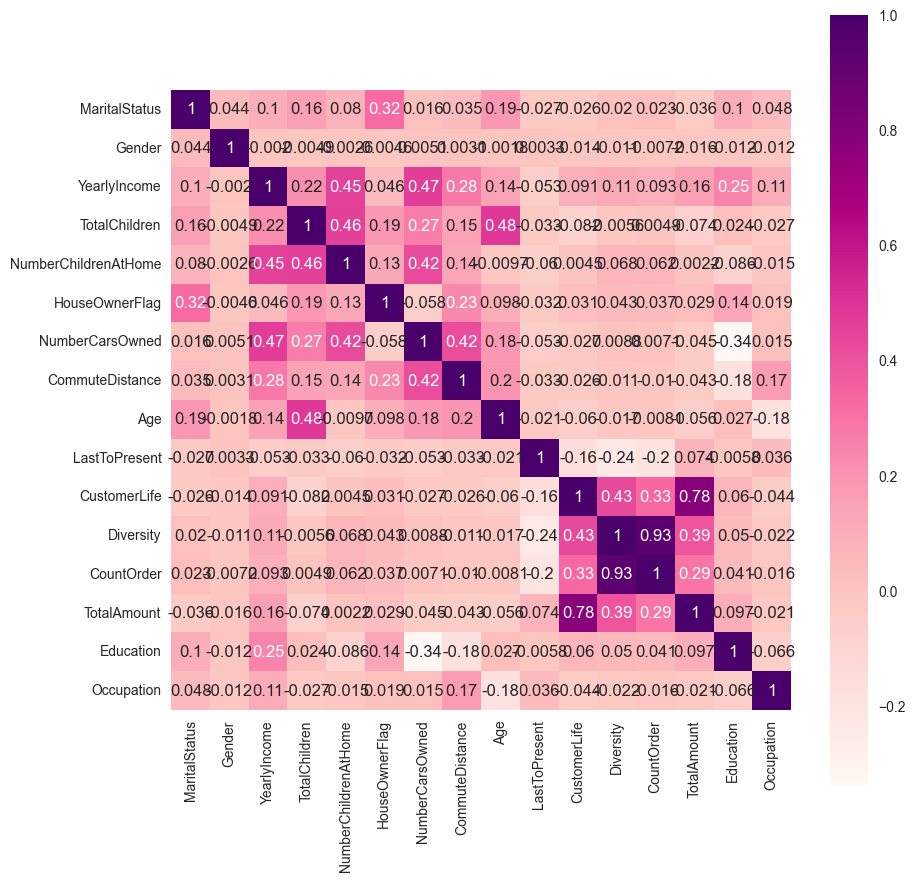

In [60]:
#Biểu đồ tương quan giữa các đặc trưng
plt.figure(figsize=(10,10))
sns.heatmap(df_customer_kmean.corr(),annot=True,square=True,cmap='RdPu')
plt.show()

#### Tìm cụm K cho mô hình KMeans trong SSAS

In [75]:
#Trích xuất dữ liệu để xây dựng mô hình KMeans trong SSAS
df_customer_kmean_ssas = df_customer_kmean[
  ['MaritalStatus', 'Gender', 'YearlyIncome', 'TotalChildren',
   'Age', 'LastToPresent', 'CountOrder', 'TotalAmount', 'Education', 'Occupation']]

In [76]:
#Chuẩn hóa dữ liệu bằng phương pháp Z-score
scaler = StandardScaler()
df_customer_kmean_ssas_scaled = scaler.fit_transform(df_customer_kmean_ssas)
X_ssas_scaled = pd.DataFrame(df_customer_kmean_ssas_scaled, 
                        columns=df_customer_kmean_ssas.columns)

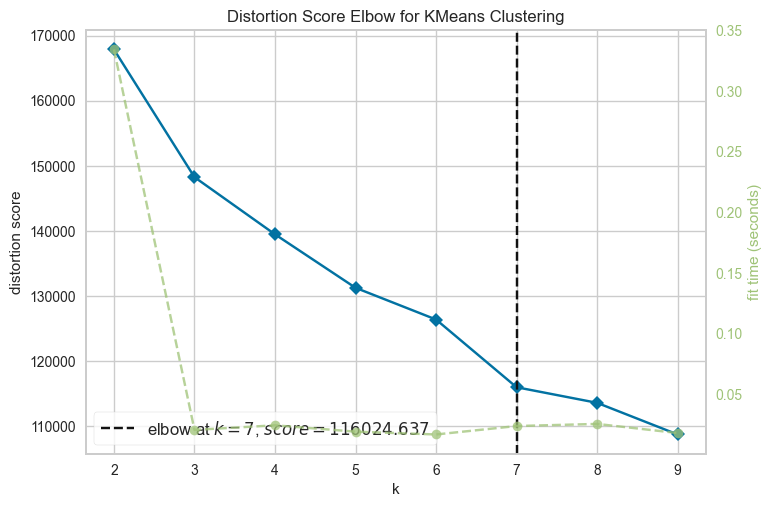

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [80]:
#Tìm K tối ưu cho KMeans trong SSAS với phương pháp Elbow
kmean_ssas_test = KMeans(random_state=21, max_iter=600, n_init='auto')
visualizer = KElbowVisualizer(kmean_ssas_test, k=(2,10))
visualizer.fit(X_ssas_scaled)
visualizer.show()

In [81]:
#Chèn lại cột CustomerKey vào df_customer_kmean_ssas để dễ dàng nhận diện
df_customer_kmean_ssas.insert(0, 'CustomerKey', df_customer['CustomerKey'])
#Xuất dữ liệu để dùng trong SSAS
df_customer_kmean_ssas.to_csv('data/Dataset_KMeans_SSAS.csv', index=False)

#### K-Means với dữ liệu giảm chiều

In [90]:
#Chuẩn hóa dữ liệu bằng phương pháp Z-score
df_customer_kmean_scaled = scaler.fit_transform(df_customer_kmean)
X_scaled = pd.DataFrame(df_customer_kmean_scaled, 
                        columns=df_customer_kmean.columns)

In [91]:
#Giảm chiều dữ liệu với PCA
pca = PCA(random_state=21, n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [92]:
#Mô tả dữ liệu sau khi giảm chiều
df_X_pca = pd.DataFrame(X_pca, columns=['col1', 'col2', 'col3'])
df_X_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,18484.0,-7.380665e-17,1.648795,-3.277957,-1.162534,-0.313037,0.845521,18.966794
col2,18484.0,3.382805e-17,1.594914,-5.273838,-1.145266,0.176643,1.143819,7.291442
col3,18484.0,2.152694e-17,1.249677,-3.559551,-0.915434,-0.007730,0.896872,4.330502


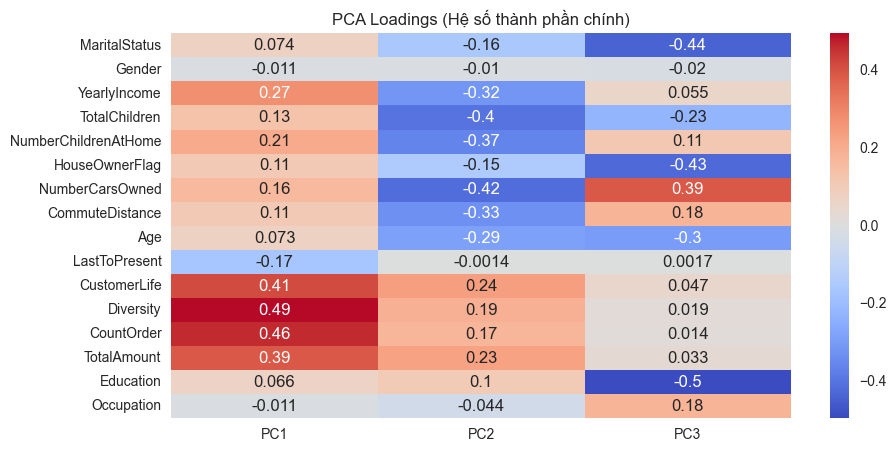

In [93]:
#Xem mức độ đóng góp của các thành phần chính
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], 
                        index=X_scaled.columns)
plt.figure(figsize=(10, 5))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings (Hệ số thành phần chính)")
plt.show()

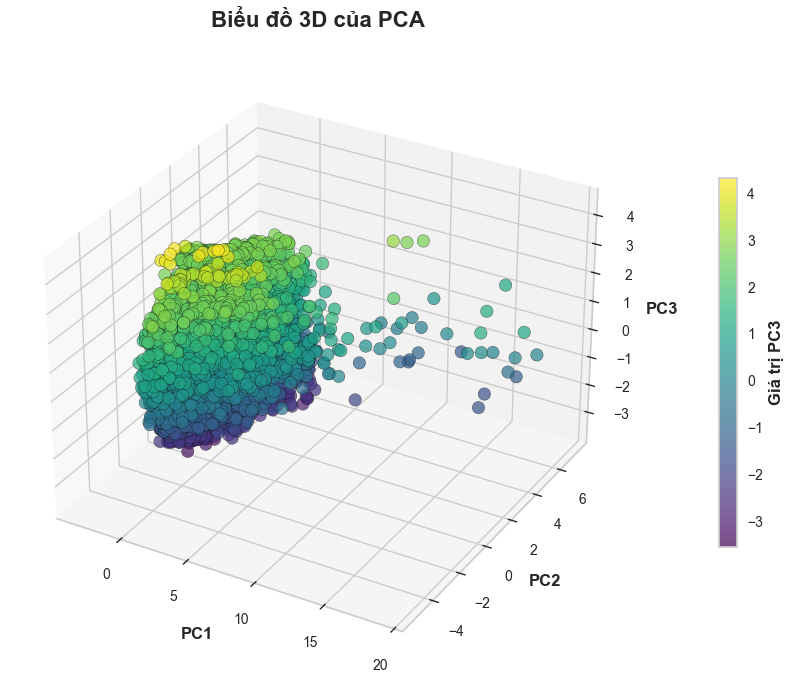

In [94]:
#Biểu đồ 3D thể hiện sự phân bố của dữ liệu sau giảm chiều
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, projection='3d', facecolor='none')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=X_pca[:, 2],
                     cmap="viridis",
                     edgecolors='k',
                     s=80,
                     alpha=0.7,
                     depthshade=True)

ax.set_xlabel("PC1", fontsize=12, labelpad=10, fontweight='bold')
ax.set_ylabel("PC2", fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel("PC3", fontsize=12, labelpad=10, fontweight='bold')

ax.set_title("Biểu đồ 3D của PCA", fontsize=16, pad=20, fontweight='bold')

legend = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
legend.set_label("Giá trị PC3", fontsize=12, fontweight='bold')
legend.ax.tick_params(labelsize=10)

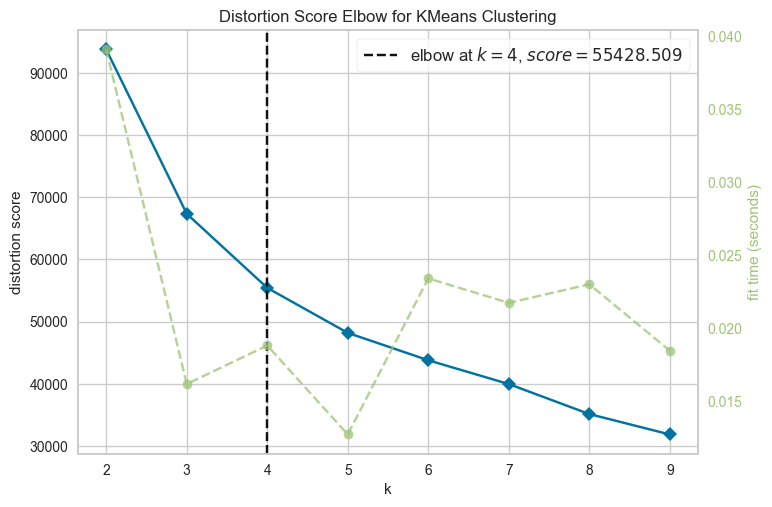

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#Tìm K trên dữ liệu đã giảm chiều
kmean_model = KMeans(random_state=21, n_init='auto', max_iter=500)
visualizer = KElbowVisualizer(kmean_model, k=(2,10))
visualizer.fit(X_pca)
visualizer.show()

In [97]:
#Xây dựng mô hình KMeans với số cụm là 4
kmeans = KMeans(n_clusters=4, random_state=21, max_iter=500, n_init='auto')
kmeans.fit(X_pca)

KMeans(max_iter=500, n_clusters=4, random_state=21)

In [98]:
#Đánh giá độ tốt của cụm
print(silhouette_score(X_pca, kmeans.labels_))
print(davies_bouldin_score(X_pca, kmeans.labels_))

0.28792411240109883
1.0574171802628307


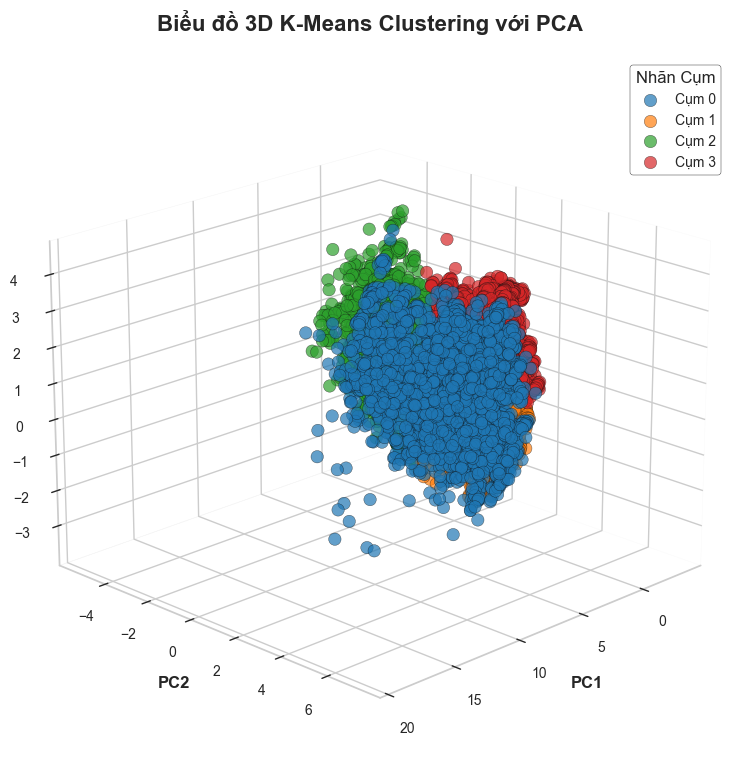

In [99]:
#Biểu đồ 3D thể hiện sự phân bố dữ liệu của các cụm
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, projection='3d', facecolor='none')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

for i in np.unique(kmeans.labels_):
  ax.scatter(X_pca[kmeans.labels_ == i, 0],
              X_pca[kmeans.labels_ == i, 1],
              X_pca[kmeans.labels_ == i, 2],
              label=f'Cụm {i}',
              s=80,
              alpha=0.7,
              edgecolors='k',
              c=colors[i % len(colors)],
              depthshade=True)

ax.set_xlabel("PC1", fontsize=12, labelpad=10, fontweight='bold')
ax.set_ylabel("PC2", fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel("PC3", fontsize=12, labelpad=10, fontweight='bold')

ax.set_title("Biểu đồ 3D K-Means Clustering với PCA", fontsize=16, pad=20, fontweight='bold')

ax.legend(title="Nhãn Cụm",
          title_fontsize=12,
          fontsize=10,
          loc='upper right',
          frameon=True,
          edgecolor='black',
          facecolor='white',
          framealpha=0.9)

ax.view_init(elev=20, azim=45)

ax.grid(True, linestyle='--', alpha=0.5)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.dist = 12

plt.tight_layout()
plt.show()

In [103]:
pd.DataFrame(kmeans.labels_, columns=['Cluster']).value_counts().sort_index()

Cluster
0          3424
1          4889
2          5104
3          5067
Name: count, dtype: int64